In [1]:
# This cell is added by sphinx-gallery
# It can be customized to whatever you like
%matplotlib inline



Function fitting with a quantum neural network
==============================================

.. meta::
    :property="og:description": In this demonstration, we show how a variational
        circuit can be used to learn a fit for a one-dimensional function
        from noisy samples.
    :property="og:image": https://pennylane.ai/qml/_images/qnn_output_28_0.png

In this example we show how a variational circuit can be used to learn a
fit for a one-dimensional function when being trained with noisy samples
from that function.

The variational circuit we use is the continuous-variable quantum neural
network model described in `Killoran et al.
(2018) <https://arxiv.org/abs/1806.06871>`__.

Imports
~~~~~~~

We import PennyLane, the wrapped version of NumPy provided by PennyLane,
and an optimizer.


In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

The device we use is the Strawberry Fields simulator, this time with
only one quantum mode (or ``wire``). You will need to have the
Strawberry Fields plugin for PennyLane installed.



In [3]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

Quantum node
~~~~~~~~~~~~

For a single quantum mode, each layer of the variational circuit is
defined as:



In [4]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.



In [5]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

Objective
~~~~~~~~~

As an objective we take the square loss between target labels and model
predictions.



In [6]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).



In [7]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

Optimization
~~~~~~~~~~~~

We load noisy data samples of a sine function.



In [28]:
# data = np.loadtxt("data/sine.txt")
# X = data[:, 0]
# Y = data[:, 1]

n = 50
X = np.linspace(-1, 1, n)
Y = np.sin(2.5*X) + (np.random.random(n)-0.5)/3

Before training a model, let’s examine the data.

*Note: For the next cell to work you need the matplotlib library.*



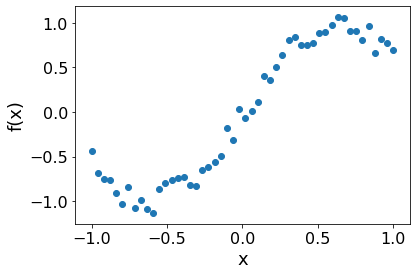

In [29]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

![](../demonstrations/quantum_neural_net/qnn_output_20_0.png)


The network’s weights (called ``var`` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.



In [10]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


.. rst-class:: sphx-glr-script-out

 Out:

 .. code-block:: none

   array([[ 0.08820262,  0.02000786,  0.0489369 ,  0.11204466,  0.0933779 ],
          [-0.04886389,  0.04750442, -0.00756786, -0.00516094,  0.02052993],
          [ 0.00720218,  0.07271368,  0.03805189,  0.00608375,  0.02219316],
          [ 0.01668372,  0.07470395, -0.01025791,  0.01565339, -0.04270479]])

Using the Adam optimizer, we update the weights for 500 steps (this
takes some time). More steps will lead to a better fit.



In [32]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(150):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.1443702 
Iter:     2 | Cost: 0.1263615 
Iter:     3 | Cost: 0.1125536 
Iter:     4 | Cost: 0.1014877 
Iter:     5 | Cost: 0.0924946 
Iter:     6 | Cost: 0.0851991 
Iter:     7 | Cost: 0.0793558 
Iter:     8 | Cost: 0.0747806 
Iter:     9 | Cost: 0.0713175 
Iter:    10 | Cost: 0.0688211 
Iter:    11 | Cost: 0.0671487 
Iter:    12 | Cost: 0.0661565 
Iter:    13 | Cost: 0.0657006 
Iter:    14 | Cost: 0.0656392 
Iter:    15 | Cost: 0.0658373 
Iter:    16 | Cost: 0.0661709 
Iter:    17 | Cost: 0.0665319 
Iter:    18 | Cost: 0.0668318 
Iter:    19 | Cost: 0.0670043 
Iter:    20 | Cost: 0.0670058 
Iter:    21 | Cost: 0.0668156 
Iter:    22 | Cost: 0.0664331 
Iter:    23 | Cost: 0.0658748 
Iter:    24 | Cost: 0.0651700 
Iter:    25 | Cost: 0.0643565 
Iter:    26 | Cost: 0.0634757 
Iter:    27 | Cost: 0.0625688 
Iter:    28 | Cost: 0.0616737 
Iter:    29 | Cost: 0.0608217 
Iter:    30 | Cost: 0.0600369 
Iter:    31 | Cost: 0.0593349 
Iter:    32 | Cost: 0.0587234 
Iter:   

In [33]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

and plot the shape of the function that the model has “learned” from
the noisy data (green dots).



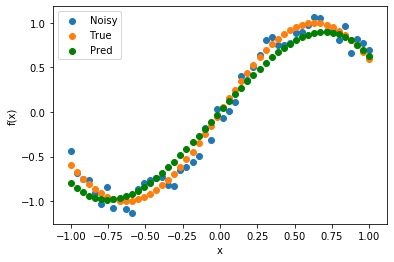

In [34]:
plt.figure()
plt.scatter(X, Y, label="Noisy")
plt.scatter(X, np.sin(2.5*X), label="True")
plt.scatter(x_pred, predictions, color="green", label="Pred")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.legend()
plt.show()

![](../demonstrations/quantum_neural_net/qnn_output_28_0.png)


The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).



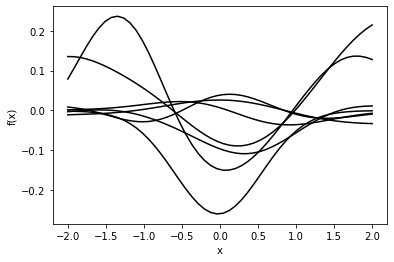

In [14]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

![](../demonstrations/quantum_neural_net/qnn_output_30_0.png)


